<a href="https://colab.research.google.com/github/havaledar/6100_final_project/blob/main/data6100_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary

Test

In this notebook, we are going to estimate the New York City Taxi Fare by Linear Regression. It used to be a competition organized by Kaggle in partnership with Google Cloud and Coursera [here](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview). In order to estimate it, the following steps were done.

1. The train and test data provided by Kaggle imported, cleaned and preapred for runing the model.
2. Outliers in the train set were removed based on the test set ranges.
3. Based on the RSS of the Linear Regression and Histogram-based Gradient Boosting Regression Tree in 5 folds cross validation, the final model was deployed by Histogram-based Gradient Boosting Regression Tree on all train data.


# Kaggle Score

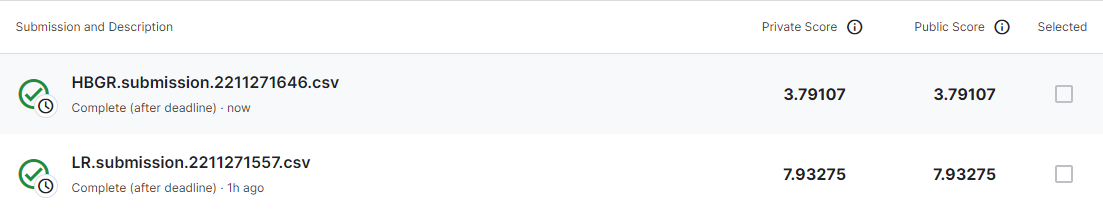

- HBGR.submission.2211271646.csv
    - **Histogram-based Gradient Boosting Regression Tree**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Score: **3.79107**
- LR.submission.2212271557.csv
    - **Simple linear regression**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Score: **7.93275**

# Ethics



1.   Although releasing the fare prices could increase the transparency and fairness but it can cause problems like the following ones
  1.   People or drivers may compare the prices regardless of time and location and expect the same amount for the similar situation while a single condition could change the price dramatically. 
  2.   Drivers tend to go to the palces with more price. Not only it may cause a traffic in certain areas and makes the life of residents in this area difficult but also it could result in difficulties in finding a taxi in cheaper areas.
2.   If the estimation is not correct, drivers may be forced to receive less or more than what they should. The same could be true for customers.
3. Because of exact time of arrival and departure privacy of people could be jeop·ard·ized. For example, if you know your friend works in Uber and he is in the specific location at certain time, you could understand where he goes afterwards or before.
4. It could bring some security issues. For example, criminals could find routes with less traffic for escaping. Or if they know someone takes taxi regularly they could find the origin and destination and do some criminal acts.



# Data Wrangling

## Loading libraries

First we import libraries used in the the notebook as below.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
import pytz
from datetime import datetime, timezone

pd.set_option('display.min_rows', 4)

Then, we retrieve all the data provided by Kaggle and then extract them. 

In [ ]:
!wget -q --show-progress -O new-york-city-taxi-fare-prediction.zip https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ESnzvg-NHEhPgoURZmVYv1MBUS3GVlHGGUTbnBRS10J3Eg?download=1
!unzip new-york-city-taxi-fare-prediction.zip

new-york-city-taxi- 100%[===================>]   1.56G   106MB/s    in 18s     
Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Read data (train + test)

Next, we load both train and text data and concatenate them to one dataframe so that we transform both datasets the same. Here we added multiple columns to the dataframe and illustrate this in the following table.

Before | After
--- | ---
key|key
fare_amount|fare_amount
pickup_datetime|pickup_datetime
pickup_longitude|pickup_longitude
pickup_latitude|pickup_latitude
dropoff_longitude|dropoff_longitude
dropoff_latitude|dropoff_latitude
passenger_count|passenger_count
|dataset
|year
|month
|day
|weekday
|hour
|minute

By summarizing the data per train and test dataset, we conclude that some observations in training data are out of range i.e. outside the range of test data.

In [ ]:
# Read dataset (train + test)

df = (
    pd.concat([
        (pd.read_csv('train.csv', nrows=100_000)    # read nrows ONLY, the whole set contains >55M rows
         .assign(dataset='train')),
        (pd.read_csv('test.csv')
         .assign(dataset='test')),
    ])
    .assign(
        pickup_datetime=lambda x: pd.to_datetime(x.pickup_datetime),
        year   =lambda x: x.pickup_datetime.dt.year,
        month  =lambda x: x.pickup_datetime.dt.month,
        day    =lambda x: x.pickup_datetime.dt.day,
        weekday=lambda x: x.pickup_datetime.dt.weekday,
        hour   =lambda x: x.pickup_datetime.dt.hour,
        minute =lambda x: x.pickup_datetime.dt.minute,
     )
)
trainset = df.dataset == 'train'
testset  = df.dataset == 'test'

print(f'train: {trainset.sum()}, test: {testset.sum()}')
#display(df)

# Simple description of train and test data

df.groupby('dataset').describe().stack()

train: 100000, test: 9914


fare_amount  pickup_longitude  pickup_latitude  \
dataset                                                           
test    count       0.000000       9914.000000      9914.000000   
        mean             NaN        -73.974722        40.751041   
        std              NaN          0.042774         0.033541   
        min              NaN        -74.252193        40.573143   
        25%              NaN        -73.992501        40.736125   
        50%              NaN        -73.982326        40.753051   
        75%              NaN        -73.968013        40.767113   
        max              NaN        -72.986532        41.709555   
train   count  100000.000000     100000.000000    100000.000000   
        mean       11.354652        -72.494682        39.914481   
        std         9.716777         10.693934         6.225686   
        min       -44.900000       -736.550000       -74.007670   
        25%         6.000000        -73.992041        40.734996   
        50%         8.500000        -73.981789        40.752765   
        75%        12.500000        -73.966982        40.767258   
        max       200.000000         40.787575       401.083332   

               dropoff_longitude  dropoff_latitude  passenger_count  \
dataset                                                               
test    count        9914.000000       9914.000000      9914.000000   
        mean          -73.973657         40.751743         1.671273   
        std             0.039072          0.035435         1.278747   
        min           -74.263242         40.568973         1.000000   
        25%           -73.991247         40.735254         1.000000   
        50%           -73.980015         40.754065         1.000000   
        75%           -73.964059         40.768757         2.000000   
        max           -72.990963         41.696683         6.000000   
train   count      100000.000000     100000.000000    100000.000000   
        mean          -72.490967         39.919053         1.673820   
        std            10.471386          6.213427         1.300171   
        min           -84.654241        -74.006377         0.000000   
        25%           -73.991215         40.734182         1.000000   
        50%           -73.980000         40.753243         1.000000   
        75%           -73.963433         40.768166         2.000000   
        max            40.851027        404.616667         6.000000   

                        year          month            day        weekday  \
dataset                                                                     
test    count    9914.000000    9914.000000    9914.000000    9914.000000   
        mean     2011.815816       6.857979      16.194170       2.852834   
        std         1.803347       3.353272       8.838482       1.994451   
        min      2009.000000       1.000000       1.000000       0.000000   
        25%      2010.000000       4.000000       9.000000       1.000000   
        50%      2012.000000       7.000000      16.000000       3.000000   
        75%      2014.000000      10.000000      25.000000       5.000000   
        max      2015.000000      12.000000      31.000000       6.000000   
train   count  100000.000000  100000.000000  100000.000000  100000.000000   
        mean     2011.743890       6.261230      15.664270       3.036180   
        std         1.866020       3.450569       8.677631       1.949484   
        min      2009.000000       1.000000       1.000000       0.000000   
        25%      2010.000000       3.000000       8.000000       1.000000   
        50%      2012.000000       6.000000      16.000000       3.000000   
        75%      2013.000000       9.000000      23.000000       5.000000   
        max      2015.000000      12.000000      31.000000       6.000000   

                        hour         minute  
dataset                                      
test    count    9914.000000    9914.000000  
      

## Preprocess data

In this section, we
1. divide the dataframe to train and test datasets;  
2. remove existing outliers in train data based on the test data ranges. Revomed data is %2.5 of the observations; 
3. make sure there is no NA in the train dataset and the X and y have the same length before fitting the model; and
4. standardise the variables to treat all vriables evenly.

In [ ]:
# Input and output variables
cols_X = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'year',
    'month',
    'day',
    'weekday',
    'hour',
    'minute',
]
col_y = 'fare_amount'

# Determine
# which record is out-of-range -- to drop
# which record is within-range -- to keep

testset_max = df[testset][cols_X].max()    # max values in test set
testset_min = df[testset][cols_X].min()    # min values in test set

trainset_to_drop = (trainset
                    &
                    ((df[cols_X] > testset_max).any(axis=1)     # > max
                     |
                     (df[cols_X] < testset_min).any(axis=1))    # or < min
                   )
trainset_to_keep = trainset & ~trainset_to_drop

print(f'train: {trainset.sum()}, test: {testset.sum()}')
print('train to drop:', trainset_to_drop.sum(), 'train to keep:', trainset_to_keep.sum())

train: 100000, test: 9914
train to drop: 2512 train to keep: 97488


In [ ]:
# Make sure there is no NA
assert df[trainset_to_keep][cols_X].notna().all().all()
assert df[trainset_to_keep][col_y].notna().all().all()

# Standardize X and y  (X_train and y_train)
sr_mean_X, sr_std_X = df[cols_X].mean(), df[cols_X].std()
X_train = ((df[trainset_to_keep][cols_X] - sr_mean_X) / sr_std_X).values
y_train = df[trainset_to_keep][col_y].values

X_train.shape, y_train.shape

((97488, 11), (97488,))

# Correlation Matrix

In [ ]:
df[trainset].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
 8   dataset            100000 non-null  object             
 9   year               100000 non-null  int64              
 10  month              100000 non-null  int64              
 11  day                100000 non-null  int64              
 12  weekday            100000 non-n

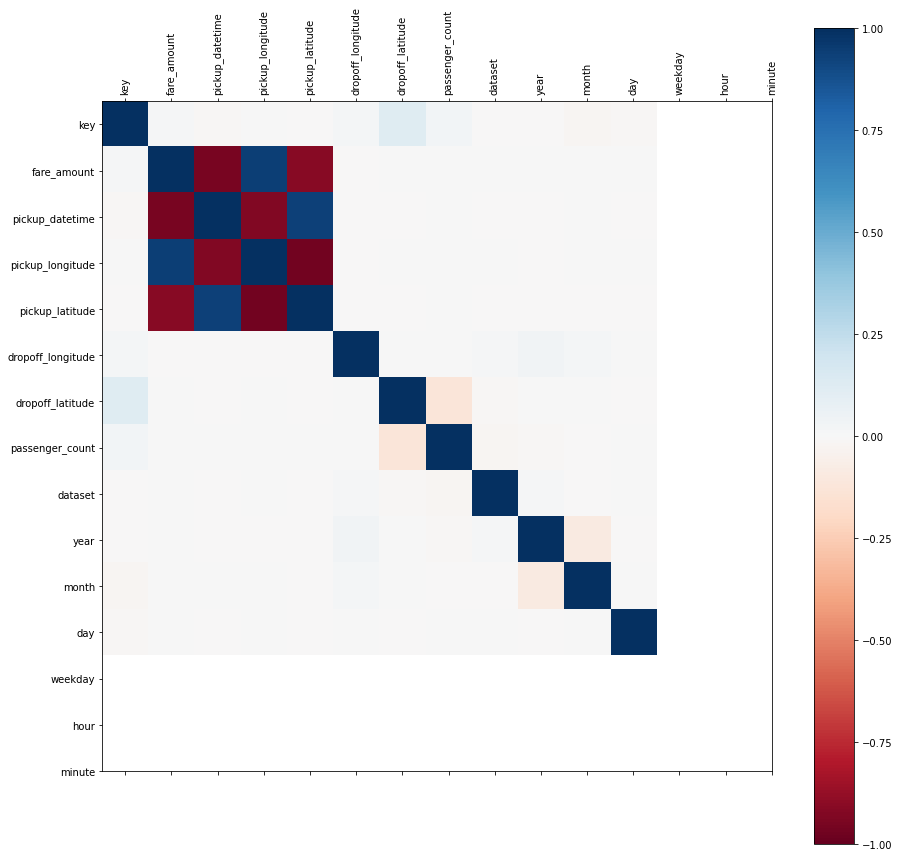

In [ ]:
#todo: last 3 columns are not displaying. Why there is almost no correlation between X and y? 

corr = df[trainset].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df[trainset].columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df[trainset].columns)
ax.set_yticklabels(df[trainset].columns)
fig.set_size_inches(15, 15)
plt.show()

# Model Deployment

In this section, we predict the fares based on with the following models.
1.   Linear Regression
2.   Histogram-based Gradient Boosting Regression Tree

## Linear Regression

In [ ]:
model = LinearRegression()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-validation scores: [7.98677275 8.14558127 8.16869135 8.2101265  8.30146526]
Mean cross-validation score: 8.16252742260408


###Forward Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs_forward = SequentialFeatureSelector(model, direction="forward").fit(df[trainset][cols_X], df[trainset][col_y])
print("Top {} features selected by forward sequential selection:{}"\
      .format(len(sfs_forward.get_feature_names_out()), sfs_forward.get_feature_names_out()))

Top 5 features selected by forward sequential selection:['passenger_count' 'year' 'month' 'hour' 'minute']


### Backward Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs_backward = SequentialFeatureSelector(model, direction="backward").fit(df[trainset][cols_X], df[trainset][col_y])
print("Top {} features selected by forward sequential selection:{}"\
      .format(len(sfs_backward.get_feature_names_out()), sfs_backward.get_feature_names_out()))

Top 5 features selected by forward sequential selection:['passenger_count' 'year' 'month' 'hour' 'minute']


In [ ]:
# Linear Regression with all variables
import statsmodels.api as sm
sm.OLS(df[trainset][col_y],df[trainset][cols_X]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            fare_amount   R-squared (uncentered):                   0.578
Model:                            OLS   Adj. R-squared (uncentered):              0.578
Method:                 Least Squares   F-statistic:                          1.245e+04
Date:                Sat, 03 Dec 2022   Prob (F-statistic):                        0.00
Time:                        04:30:29   Log-Likelihood:                     -3.6919e+05
No. Observations:              100000   AIC:                                  7.384e+05
Df Residuals:                   99989   BIC:                                  7.385e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude      0.0129      0.010      1.228      0.219      -0.008       0.033
pickup_latitude      -0.0298      0.018     -1.672      0.095      -0.065       0.005
dropoff_longitude    -0.0050      0.013     -0.379      0.705      -0.031       0.021
dropoff_latitude      0.0300      0.020      1.481      0.139      -0.010       0.070
passenger_count       0.1193      0.024      5.048      0.000       0.073       0.166
year                  0.0059      0.000     46.738      0.000       0.006       0.006
month                 0.0691      0.009      7.761      0.000       0.052       0.086
day                  -0.0011      0.004     -0.299      0.765      -0.008       0.006
weekday              -0.0142      0.016     -0.898      0.369      -0.045       0.017
hour                 -0.0285      0.005     -6.016      0.000      -0.038      -0.019
minute               -0.0063      0.002     -3.535      0.000      -0.010      -0.003
==============================================================================
Omnibus:                    77740.205   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2191332.512
Skew:                           3.549   Prob(JB):                         0.00
Kurtosis:                      24.807   Cond. No.                     1.63e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Linear Regression with selected variables
import statsmodels.api as sm
sm.OLS(df[trainset][col_y],df[trainset][sfs_backward.get_feature_names_out()]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            fare_amount   R-squared (uncentered):                   0.578
Model:                            OLS   Adj. R-squared (uncentered):              0.578
Method:                 Least Squares   F-statistic:                          2.738e+04
Date:                Sat, 03 Dec 2022   Prob (F-statistic):                        0.00
Time:                        04:30:36   Log-Likelihood:                     -3.6920e+05
No. Observations:              100000   AIC:                                  7.384e+05
Df Residuals:                   99995   BIC:                                  7.385e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
passenger_count     0.1181      0.024      5.001      0.000       0.072       0.164
year                0.0056   5.51e-05    101.804      0.000       0.006       0.006
month               0.0692      0.009      7.774      0.000       0.052       0.087
hour               -0.0281      0.005     -5.962      0.000      -0.037      -0.019
minute             -0.0063      0.002     -3.536      0.000      -0.010      -0.003
==============================================================================
Omnibus:                    77743.764   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2191049.444
Skew:                           3.550   Prob(JB):                         0.00
Kurtosis:                      24.805   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Histogram-based Gradient Boosting Regression Tree

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

model = HistGradientBoostingRegressor()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-valid:ation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-valid:ation scores: [4.12446876 4.48269678 4.59835299 4.47641368 4.26700344]
Mean cross-validation score: 4.389787130202018


# Fit a final model

As we can see the RSS for the Histogram-based Gradient Boosting Regression Tree is less than Linear Regression, we choose Histogram-based Gradient Boosting Regression Tree to fit the the model with all train data once more before prediction.

In [ ]:
# Final model

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

X_test = ((df[testset][cols_X] - sr_mean_X) / sr_std_X).values
y_hat = model.predict(X_test)

X_test.shape, y_hat.shape

((9914, 11), (9914,))

# Make a submission CSV

Finally, we create the CSV file based on sample submission file to submit in Kaggle.

In [ ]:
# make submission csv
df_submission = pd.DataFrame({
    'key'        : df[testset]['key'],
    'fare_amount': y_hat,
})

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")
save_path = f'submission.{timestr}.csv'
df_submission.to_csv(save_path, index=False)
print('saved to', save_path)

saved to submission.2212022227.csv


-todo
  - transforming long and lat to neighbourhood
  - Using more data in train set against limitation in colab
  - Doing Forward and Backward selections in regression
  - deploying more powerful models e.g. timeseries, KNN, Neural Network

